![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting Nexus data 


In [7]:
import os ,sys, time, logging,shutil,copy
from datetime import datetime
import numpy as np

#sys.path.append("C:/projects/OpenVisus/build/RelWithDebInfo")
#sys.path.append("C:/projects/openvisuspy/src")

import OpenVisus as ov
import openvisuspy
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")

# uncomment for debugging
# ov.SetupLogger(logger, stream=True)

print("OpenVisus imported")

OpenVisus imported


In [2]:
from nexusformat.nexus import * 
from nexusformat.nexus.tree import NX_CONFIG 

# alllow data to be 16000MB (i.e. 16GB)
NX_CONFIG['memory']=16000 

local_nexus_filename="/mnt/data/chess/assets/3scans_HKLI.nxs"
nx=nxload(local_nexus_filename)
print(local_nexus_filename,"loaded")

/mnt/data/chess/assets/3scans_HKLI.nxs loaded


# Using nexus `tree` to traverse the file

In [3]:
from pprint import pprint
pprint(nx.tree)

('root:NXroot\n'
 "  @HDF5_Version = '1.12.1'\n"
 "  @file_name = '/nfs/chess/id4baux/2022-3/clancy-3316-a/CaYIrO...'\n"
 "  @file_time = '2022-12-14T22:23:39.738282'\n"
 "  @h5py_version = '3.7.0'\n"
 "  @nexusformat_version = '0.7.6'\n"
 '  entry:NXentry\n'
 '    data:NXdata\n'
 "      @axes = ['H', 'K', 'L']\n"
 "      @signal = 'counts'\n"
 '      H = float32(1420)\n'
 "        @long_name = 'H'\n"
 '      K = float32(1420)\n'
 "        @long_name = 'K'\n"
 '      L = float32(310)\n'
 "        @long_name = 'L'\n"
 '      counts = float32(1420x1420x310)\n'
 "        @long_name = 'counts'")


# Using openviuspy to traverse the file

In [8]:
from openvisuspy.convert_nexus import ConvertNexus
ConvertNexus.print(nx)

root::<class 'nexusformat.nexus.tree.NXroot'>
  @HDF5_Version = 1.12.1
  @file_name = /nfs/chess/id4baux/2022-3/clancy-3316-a/CaYIrO/SC4_1/300/3scans_HKLI.nxs
  @file_time = 2022-12-14T22:23:39.738282
  @h5py_version = 3.7.0
  @nexusformat_version = 0.7.6
   entry::<class 'nexusformat.nexus.tree.NXentry'>
      data::<class 'nexusformat.nexus.tree.NXdata'>
      @axes = ['H', 'K', 'L']
      @signal = counts
         H::<class 'nexusformat.nexus.tree.NXfield'>
        @long_name = H
         K::<class 'nexusformat.nexus.tree.NXfield'>
        @long_name = K
         L::<class 'nexusformat.nexus.tree.NXfield'>
        @long_name = L
         counts::<class 'nexusformat.nexus.tree.NXfield'> shape=(1420, 1420, 310) dtype=float32 ***********************************
        @long_name = counts


# Example of plot with proper names/limits

Nexus load done dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


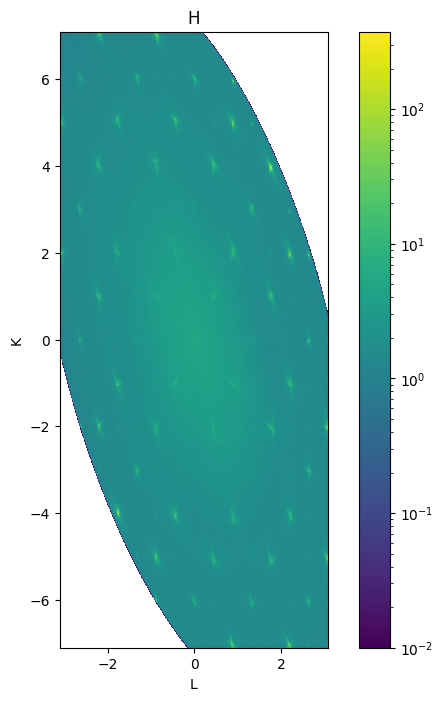

Nexus load done dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


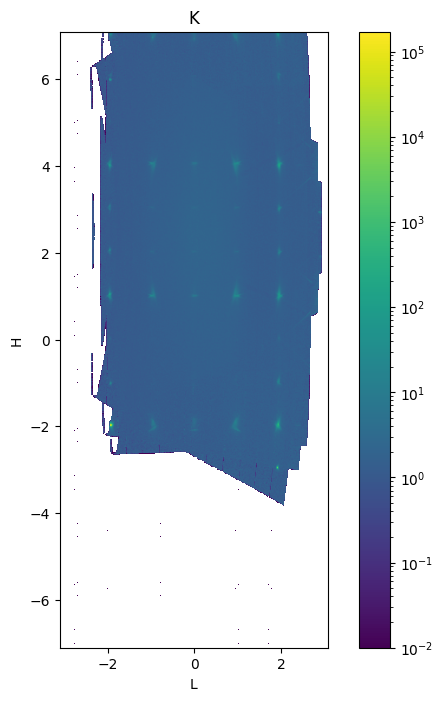

Nexus load done dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


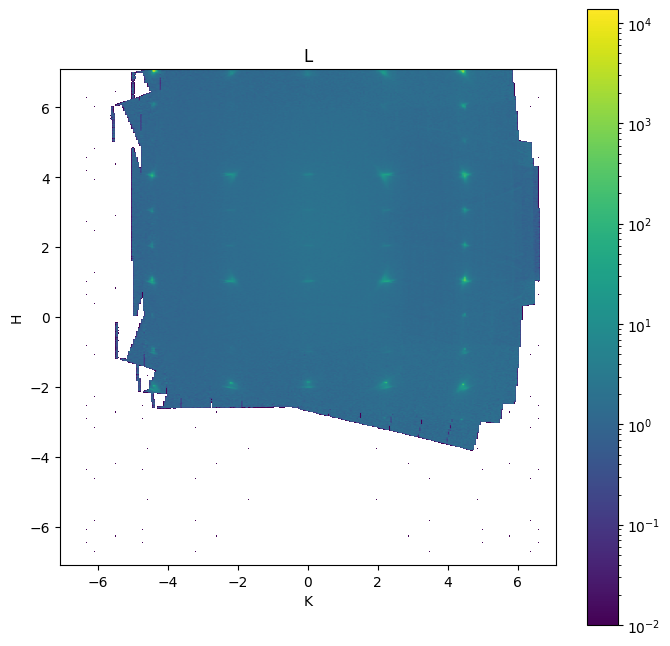

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def ShowSlice(nxdata, A=None, img=None, figsize=(8, 8), cmap="viridis", log=True):

    # all this part is Nexus specific to find
    # - axis names
    # - physical coordinates
    if True:
        axis=[nxdata[it] for it in nxdata.attrs["axes"]]
        assert(all([isinstance(it,NXfield) for it in axis]))
        H,K,L=axis
        
        signal=nxdata[nxdata.attrs["signal"]]
        assert(isinstance(signal,NXfield))
        
        print(f"Nexus load done dtype={signal.dtype} shape={signal.shape}")
        
        project=[ (0,1,2),  (1,0,2),  (2,0,1) ]
        
        # ranges are in 'physical coordinates'
        ranges=[(axis[I].nxdata[0], axis[I].nxdata[-1]) for I in range(3)]
        print(ranges)
        
        D,H,W=signal.shape
        Y1,Y2,MY= 0, D, D//2
        Z1,Z2,MZ= 0, H, H//2
        X1,X2,MX= 0, W, W//2
        
        axis_name=axis[A].nxname
        Z,Y,X=project[A]
        
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(axis_name)
        
        y1,y2=ranges[Y];ax.set_ylabel(axis[Y].nxname)
        x1,x2=ranges[X];ax.set_xlabel(axis[X].nxname)

    # todo other cases
    assert(log) 
    vmin = np.nanmin(img[img > -np.inf])
    vmax = np.nanmax(img[img <  np.inf])
    
    norm=colors.LogNorm(max(vmin, 0.01), max(vmax, 0.01))
    pos=ax.imshow(np.flip(img,axis=0),origin="upper", norm=norm, cmap=cmap,  extent=[x1,x2,y1,y2])
    
    ax.set_aspect('equal')
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    fig.colorbar(pos, ax=ax,location='right')
    plt.autoscale(True)
    plt.show()


# find an item with axes and signal as childs
# note: nxdata is the entry in the nexus tree containing axes and signal
nxdata=[node for depth, node in ConvertNexus.traverse(nx) if isinstance(node,NXdata) and "axes" in node.attrs and "signal" in node.attrs][0]

# X-slice
ShowSlice(nxdata, A=0, img=nxdata[nxdata.attrs["signal"]][:,:,200]) 

# Y slice
ShowSlice(nxdata, A=1, img=nxdata[nxdata.attrs["signal"]][:,200,:])  

# Z slice
ShowSlice(nxdata, A=2, img=nxdata[nxdata.attrs["signal"]][200,:,:]) 


# Create a Streamable OpenVisus version

In [11]:
import os,sys

t1=time.time()

# binary data will be converted to the IDX file format
local_idx_filename ="./remove-me/streamable/3scans_HKLI/visus.idx"

# I am creating a new NEXUS file without binary data which reference OpenVISUS binary data
# this version is called ` streamable`
streamable_filename="./remove-me/streamable/3scans_HKLI/visus.nxs"

# ************ dangerous (make sure you are in a tmp directory) ************ 
import os,sys,shutil
assert("remove-me" in local_idx_filename)
assert("remove-me" in streamable_filename)
shutil.rmtree(os.path.dirname(local_idx_filename), ignore_errors=True)
shutil.rmtree(os.path.dirname(streamable_filename), ignore_errors=True)

streamable=ConvertNexus(
    local_nexus_filename, 
    local_idx_filename,
    streamable=streamable_filename, 
    compression="raw" # 
).run()

print(f"Created NEXUS streamable in {time.time()-t1} seconds")

ConvertNexus::run src=/mnt/data/chess/assets/3scans_HKLI.nxs full-size=1,184,498,405
Reading Nexus field name=counts dtype=float32 shape=(1420, 1420, 310) ...
Read Nexus field in 9.466326236724854 seconds vmin=0.0 vmax=384713.5
Creating IDX file ./remove-me/streamable/3scans_HKLI/visus.idx
Found axis=L K H idx_physic_box=['-3.1', '3.08', '-7.1', '7.09', '-7.1', '7.09']
Writing IDX data...
Wrote IDX data in 3.611405372619629 seconds
Creating streamable version ./remove-me/streamable/3scans_HKLI/visus.nxs
ConvertNexus::run streamable=./remove-me/streamable/3scans_HKLI/visus.nxs reduced-size=22,760
Created NEXUS streamable in 13.128654718399048 seconds


# Show data using OpenVisus API

If we use OpenVisus we don't know real physical coordinates; and we show pixels.

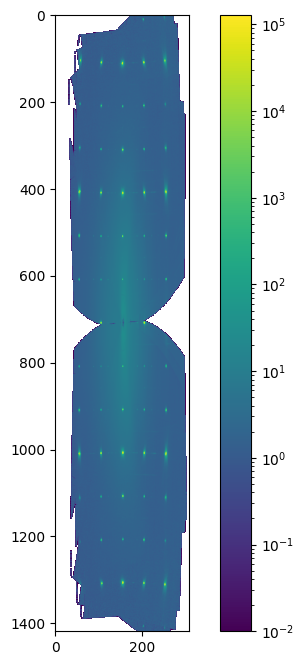

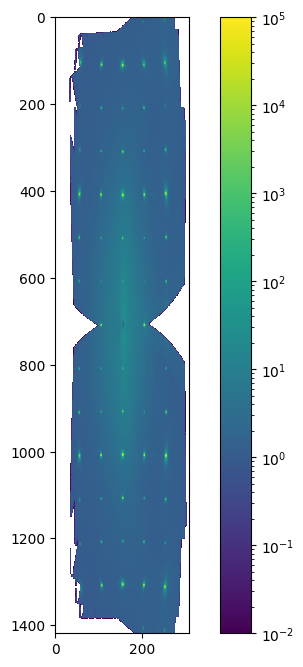

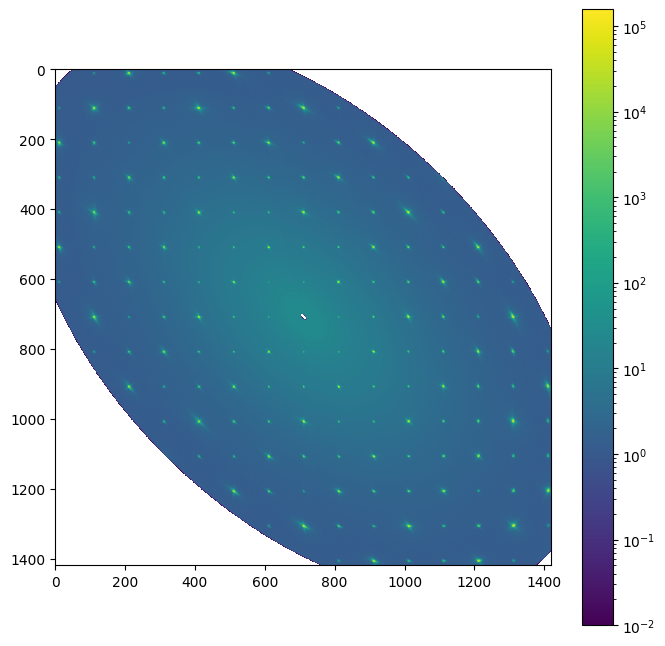

In [12]:
def ShowOpenVisusSlice(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    vmin = np.nanmin(img[img > -np.inf])
    vmax = np.nanmax(img[img <  np.inf])
    norm=colors.LogNorm(max(vmin, 0.01), max(vmax, 0.01))
    pos=ax.imshow(np.flip(img,axis=0),origin="upper", norm=norm, cmap="viridis")
    fig.colorbar(pos, ax=ax,location='right')
    plt.autoscale(True)
    plt.show()

db=ov.LoadDataset(local_idx_filename)

D,H,W=1419,1419,309
X,Y,Z=W//2,H//2,D//2
ShowOpenVisusSlice(db.read(x=[0,W],   y=[0,H],  z=[Z,Z+1], num_refinements=1)[0,:,:])
ShowOpenVisusSlice(db.read(x=[0,W],   y=[Y,Y+1],z=[0,D]  , num_refinements=1)[:,0,:])
ShowOpenVisusSlice(db.read(x=[X,X+1], y=[0,H],  z=[0,D]  , num_refinements=1)[:,:,0])

# Show slice using streamable version

The streamable version is a Nexus file (with proper metadata) without binary data.


The binary data is stored in OpenVisus datasets. But since Nexus library **DOES NOT** support reading OpenVisus binary, here we are *internally* using OpenVisus API to read binary data.

('root:NXroot\n'
 "  @HDF5_Version = '1.14.2'\n"
 "  @file_name = 'C:\\projects\\openvisuspy\\notebooks\\remove-me\\st...'\n"
 "  @file_time = '2024-05-20T17:06:48.199771'\n"
 "  @h5py_version = '3.10.0'\n"
 "  @nexusformat_version = '1.0.3'\n"
 '  @streamable = True\n'
 '  entry:NXentry\n'
 '    data:NXdata\n'
 "      @axes = ['H', 'K', 'L']\n"
 "      @signal = 'counts'\n"
 '      H = float32(1420)\n'
 "        @long_name = 'H'\n"
 '      K = float32(1420)\n'
 "        @long_name = 'K'\n"
 '      L = float32(310)\n'
 "        @long_name = 'L'\n"
 '      counts = float32(1420x1420x310)\n'
 "        @openvisus = '['./remove-me/streamable/3scans_HKLI/visus.idx']'")
Nexus load done dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


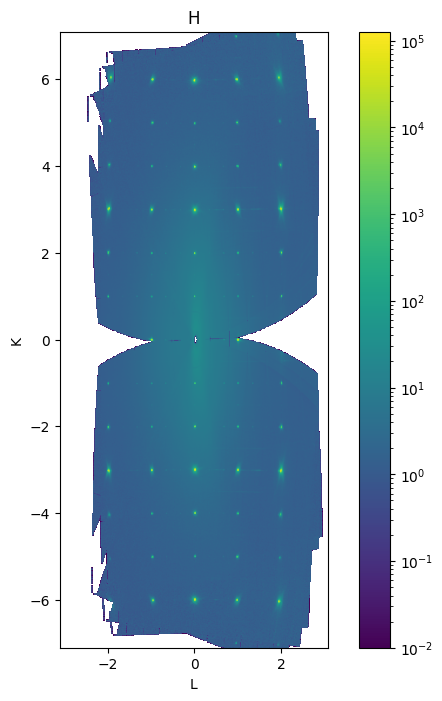

Nexus load done dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


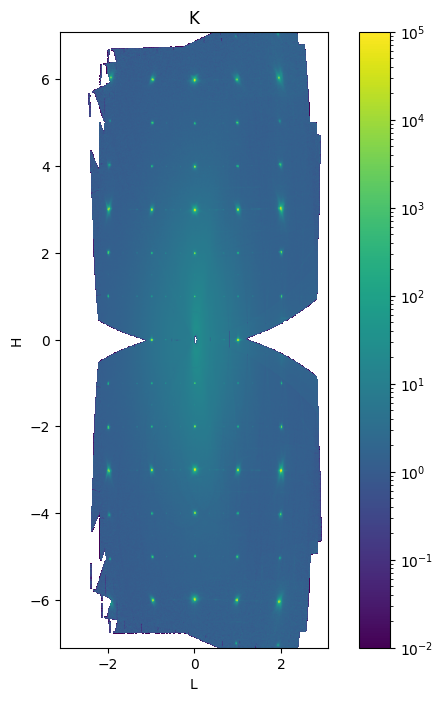

Nexus load done dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


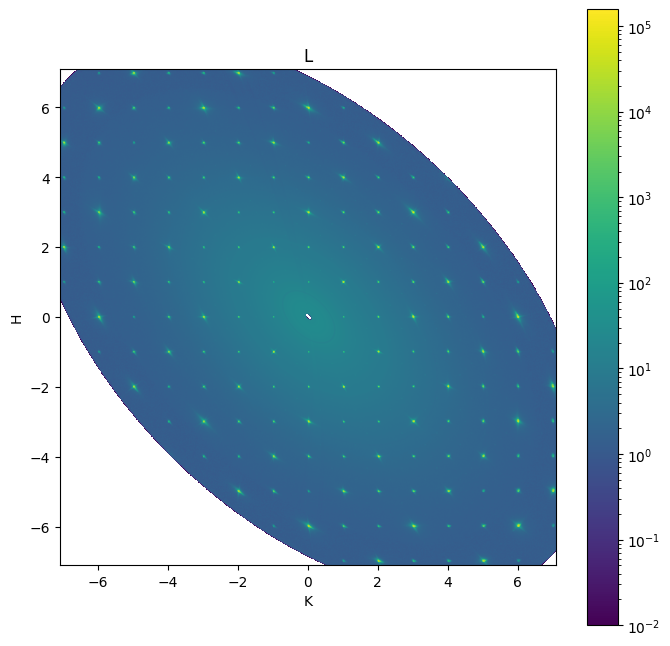

In [13]:
nx=nxload(streamable_filename)
pprint(nx.tree)
nxdata=[node for depth, node in ConvertNexus.traverse(nx) if isinstance(node,NXdata) and "axes" in node.attrs and "signal" in node.attrs][0]
db=ov.LoadDataset(local_idx_filename)
ShowSlice(nxdata, A=0, img=db.read(x=[0,W],   y=[0,H],  z=[Z,Z+1], num_refinements=1)[0,:,:]) 
ShowSlice(nxdata, A=1, img=db.read(x=[0,W],   y=[Y,Y+1],z=[0,D]  , num_refinements=1)[:,0,:])  
ShowSlice(nxdata, A=2, img=db.read(x=[X,X+1], y=[0,H],  z=[0,D]  , num_refinements=1)[:,:,0]) 